In [1]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
import os
import math
from matplotlib.colors import LogNorm

from astropy.wcs import WCS
from scipy.fftpack import fft2, fftshift
from scipy.fft import fft, fftfreq
from scipy.ndimage import map_coordinates
from astropy.wcs.utils import skycoord_to_pixel
from astropy.coordinates import SkyCoord
import astropy.units as u

from matplotlib.patches import Circle
from astropy.visualization.wcsaxes import SphericalCircle
from scipy.signal import resample
from scipy.signal import find_peaks
from matplotlib.patches import Wedge

from turbustat.statistics import PowerSpectrum
import emcee

from scipy.ndimage import gaussian_filter
import webbpsf
from scipy.ndimage import zoom
from scipy.signal import convolve2d

base_dir = "/export/home/extragal/francesco.chititegli/JWST/TESI/"

# HI Maps from THINGS (F. Walter) - Optional

Unit: JY/B*M/S


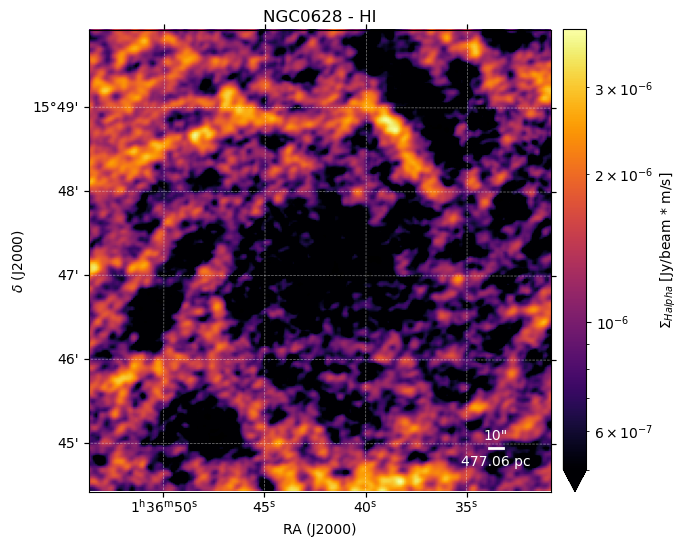

In [2]:
with fits.open(os.path.join(base_dir, "NGC_628_RO_MOM0_THINGS.FITS")) as hdul:
    #hdul.info()
    header = hdul[0].header
    image_data = hdul[0].data
wcs = WCS(header)

# I am preliminarly using a cropped frame, as the full frame is rotated wrt the FOV
y_min, y_max = 512-110, 512+110
x_min, x_max = 512-110, 512+110
cropped_image = image_data[:,:,y_min:y_max, x_min:x_max]
wcs_cropped = wcs[:,:,y_min:y_max, x_min:x_max]
wcs_cropped_HI = wcs_cropped.slice((0, 0))

# [:,:,y_min:y_max, x_min:x_max]

distance_ngc628 = 9.84 * 10**6
arcsecond_to_pc = distance_ngc628 / 206265
pixel_scale = np.abs(wcs_cropped.wcs.cdelt[0]) * 3600
arcsecond_length_in_pixels = 1 / pixel_scale

print('Unit: ' + str(header.get("BUNIT", "Unknown Unit")))
conversion_factor_Halpha = 1e-20 / (pixel_scale ** 2)
cropped_image = np.squeeze(cropped_image * conversion_factor_Halpha * 1e13)

fig, ax = plt.subplots(figsize=(8, 6), subplot_kw={'projection': wcs_cropped_HI}, dpi=100)
cmap = plt.cm.inferno.copy()
cmap.set_bad(color='black')
im = ax.imshow(cropped_image, cmap=cmap, origin="lower", norm=plt.matplotlib.colors.LogNorm(vmin=5e-7,vmax=cropped_image.max()))
ax.set_xlabel("RA (J2000)")
ax.set_ylabel("$\delta$ (J2000)")
ax.grid(color='white', linestyle='--', linewidth=0.5, alpha=0.5)

x_start = cropped_image.shape[1] - 30
y_position = 20
ax.plot([x_start, x_start + (arcsecond_length_in_pixels*10)], [y_position, y_position], color='white', lw=2)
ax.text(x_start + (arcsecond_length_in_pixels*10) / 2, y_position + 3, "10\"", color='white', va='bottom', ha='center', fontsize=10)
ax.text(x_start + (arcsecond_length_in_pixels*10) / 2, y_position - 6, f"{(arcsecond_to_pc*10):.2f} pc", color='white', va='center', ha='center', fontsize=10)

ax.set_title(r"NGC0628 - HI")
cbar = plt.colorbar(im, ax=ax, pad=0.02, extend='min')
cbar.set_label("$\Sigma_{Halpha}$ [Jy/beam * m/s]")
plt.show()

# Power Spectra and running slopes for Halpha (MUSE)

## Open the Halpha error map to calculate the Background

Unit BACKGROUND: 1e-20erg.s**(-1).cm**(-2).spaxel**(-1)


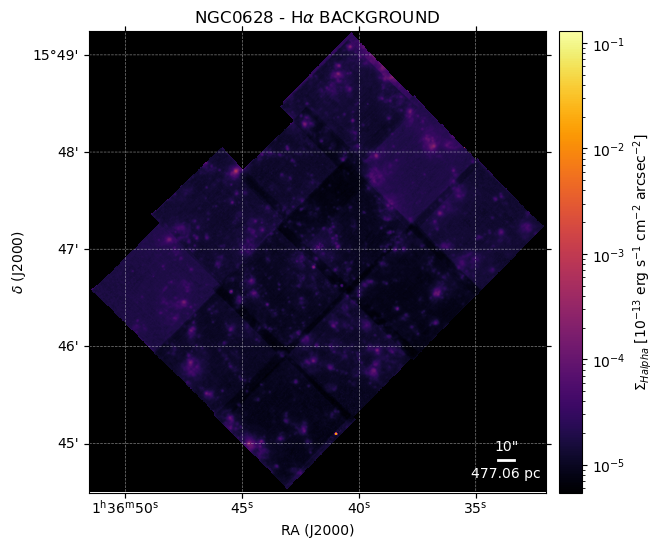

Average of the background: 1.9371360344383494e-05 as units of 1e-13 [10$^{-13}$ erg s$^{-1}$ cm$^{-2}$ arcsec$^{-2}$]


In [3]:
with fits.open(os.path.join(base_dir, "NGC0628_MAPS_copt_0.92asec.fits")) as hdul:
    #hdul.info()
    header_bkg = hdul[31].header
    image_data_bkg = hdul[31].data
    
wcs_bkg = WCS(header_bkg)

distance_ngc628 = 9.84 * 10**6
arcsecond_to_pc = distance_ngc628 / 206265
pixel_scale_bkg = np.abs(wcs_bkg.wcs.cd[1][1]) * 3600
arcsecond_length_in_pixels_bkg = 1 / pixel_scale_bkg

print('Unit BACKGROUND: ' + str(header_bkg.get("BUNIT", "Unknown Unit")))
conversion_factor_Halpha_bkg = 1e-20 / (pixel_scale_bkg ** 2)
image_data_bkg = image_data_bkg * conversion_factor_Halpha_bkg * 1e13

fig, ax = plt.subplots(figsize=(8, 6), subplot_kw={'projection': wcs_bkg}, dpi=100)
cmap = plt.cm.inferno.copy()
cmap.set_bad(color='black')
im = ax.imshow(image_data_bkg, cmap=cmap, origin="lower", norm=LogNorm())
ax.set_xlabel("RA (J2000)")
ax.set_ylabel("$\delta$ (J2000)")
ax.grid(color='white', linestyle='--', linewidth=0.5, alpha=0.5)

x_start = image_data_bkg.shape[1] - 150
y_position = 100
ax.plot([x_start, x_start + (arcsecond_length_in_pixels_bkg*10)], [y_position, y_position], color='white', lw=2)
ax.text(x_start + (arcsecond_length_in_pixels_bkg*10) / 2, y_position + 20, "10\"", color='white', va='bottom', ha='center', fontsize=10)
ax.text(x_start + (arcsecond_length_in_pixels_bkg*10) / 2, y_position - 40, f"{(arcsecond_to_pc*10):.2f} pc", color='white', va='center', ha='center', fontsize=10)

ax.set_title(r"NGC0628 - H$\alpha$ BACKGROUND ")
cbar = plt.colorbar(im, ax=ax, pad=0.02)
cbar.set_label("$\Sigma_{Halpha}$ [10$^{-13}$ erg s$^{-1}$ cm$^{-2}$ arcsec$^{-2}$]")
plt.show()

mean_background = np.nanmean(image_data_bkg)
print('Average of the background: ' + str(mean_background) + ' as units of 1e-13 [10$^{-13}$ erg s$^{-1}$ cm$^{-2}$ arcsec$^{-2}$]')

## Open the Halpha image and define scanning circles

Unit: 1e-20erg.s**(-1).cm**(-2).spaxel**(-1)


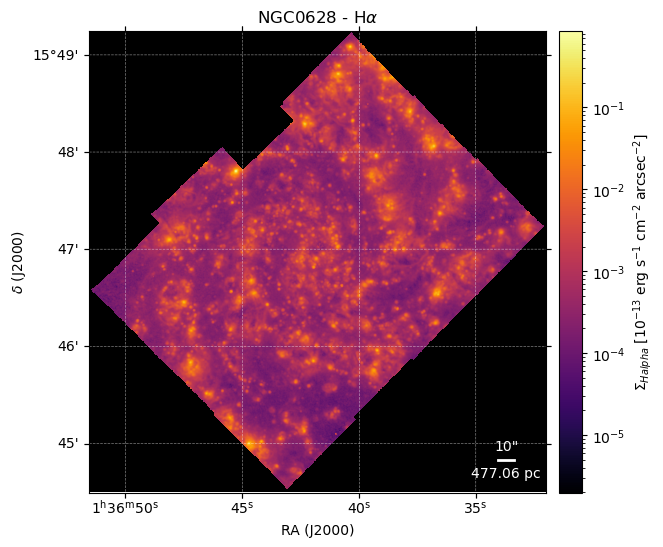

In [5]:
with fits.open(os.path.join(base_dir, "NGC0628_MAPS_copt_0.92asec.fits")) as hdul:
    #hdul.info()
    header = hdul[30].header
    image_data = hdul[30].data
wcs = WCS(header)

# I am preliminarly using a cropped frame, as the full frame is rotated wrt the FOV
y_min, y_max = 713-300, 713+300
x_min, x_max = 706-300, 706+300
seb = 400
cropped_image = image_data
wcs_cropped = wcs

# [y_min:y_max, x_min:x_max]
# [y_min+seb-80:y_max-seb-80, x_min+seb-30:x_max-seb-30]

distance_ngc628 = 9.84 * 10**6
arcsecond_to_pc = distance_ngc628 / 206265
pixel_scale = np.abs(wcs_cropped.wcs.cd[1][1]) * 3600
arcsecond_length_in_pixels = 1 / pixel_scale

print('Unit: ' + str(header.get("BUNIT", "Unknown Unit")))
conversion_factor_Halpha = 1e-20 / (pixel_scale ** 2)
cropped_image = cropped_image * conversion_factor_Halpha * 1e13

fig, ax = plt.subplots(figsize=(8, 6), subplot_kw={'projection': wcs_cropped}, dpi=100)
cmap = plt.cm.inferno.copy()
cmap.set_bad(color='black')
im = ax.imshow(cropped_image, cmap=cmap, origin="lower", norm=LogNorm())
ax.set_xlabel("RA (J2000)")
ax.set_ylabel("$\delta$ (J2000)")
ax.grid(color='white', linestyle='--', linewidth=0.5, alpha=0.5)

x_start = cropped_image.shape[1] - 150
y_position = 100
ax.plot([x_start, x_start + (arcsecond_length_in_pixels*10)], [y_position, y_position], color='white', lw=2)
ax.text(x_start + (arcsecond_length_in_pixels*10) / 2, y_position + 20, "10\"", color='white', va='bottom', ha='center', fontsize=10)
ax.text(x_start + (arcsecond_length_in_pixels*10) / 2, y_position - 40, f"{(arcsecond_to_pc*10):.2f} pc", color='white', va='center', ha='center', fontsize=10)

ax.set_title(r"NGC0628 - H$\alpha$ ")
cbar = plt.colorbar(im, ax=ax, pad=0.02)
cbar.set_label("$\Sigma_{Halpha}$ [10$^{-13}$ erg s$^{-1}$ cm$^{-2}$ arcsec$^{-2}$]")
plt.show()

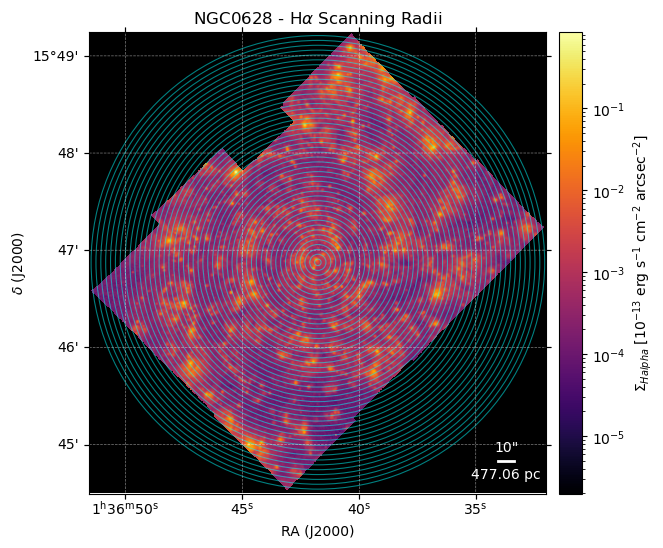

In [6]:
image_center = (cropped_image.shape[1] // 2, cropped_image.shape[0] // 2)

def generate_radii(image_shape, center, min_radius=10, max_radius=None, step=3):
    if max_radius is None:
        max_radius = min(image_shape) // 2
    return np.arange(min_radius, max_radius, step)

radii = generate_radii(cropped_image.shape, image_center)
  
fig, ax = plt.subplots(figsize=(8, 6), subplot_kw={'projection': wcs_cropped}, dpi=100)
cmap = plt.cm.inferno.copy()
cmap.set_bad(color='black')
im = ax.imshow(cropped_image, cmap=cmap, origin="lower", norm=LogNorm())
ax.set_xlabel("RA (J2000)")
ax.set_ylabel("$\delta$ (J2000)")
ax.grid(color='white', linestyle='--', linewidth=0.5, alpha=0.5)

x_start = cropped_image.shape[1] - 150
y_position = 100
ax.plot([x_start, x_start + (arcsecond_length_in_pixels*10)], [y_position, y_position], color='white', lw=2)
ax.text(x_start + (arcsecond_length_in_pixels*10) / 2, y_position + 20, "10\"", color='white', va='bottom', ha='center', fontsize=10)
ax.text(x_start + (arcsecond_length_in_pixels*10) / 2, y_position - 40, f"{(arcsecond_to_pc*10):.2f} pc", color='white', va='center', ha='center', fontsize=10)

for i, r in enumerate(radii):
    if (i % 5)==0:
        circ = Circle(image_center, r, edgecolor='cyan', facecolor='none', lw=0.8, alpha=0.5)
        ax.add_patch(circ)

ax.set_title(r"NGC0628 - H$\alpha$ Scanning Radii")
cbar = plt.colorbar(im, ax=ax, pad=0.02)
cbar.set_label("$\Sigma_{Halpha}$ [10$^{-13}$ erg s$^{-1}$ cm$^{-2}$ arcsec$^{-2}$]")
plt.show()

In [7]:
def pixels_by_radius(image, center, radii_generated, tolerance=0.5, angle_range='-pi_to_pi'):
    y_indices, x_indices = np.indices(image.shape)
    x0, y0 = center

    dx = x_indices - x0
    dy = y_indices - y0

    radius_map = np.sqrt(dx**2 + dy**2)
    angle_map = np.arctan2(dy, dx)  # valori in [-pi, pi]

    if angle_range == '0_to_2pi':
        angle_map = np.mod(angle_map, 2*np.pi)

    pixel_lists = []

    for r in radii_generated:
        mask = (np.abs(radius_map - r) <= tolerance)
        angles = angle_map[mask]
        values = image[mask]

        coords_y, coords_x = np.where(mask)
        coords = np.column_stack((coords_y, coords_x, values))

        sorted_indices = np.argsort(angles)
        sorted_coords = coords[sorted_indices]

        pixel_lists.append(sorted_coords)

    return pixel_lists


pixels_data = pixels_by_radius(cropped_image, image_center, radii)

# Theoretical will be higher by default
print('Min number of pixels slices ' + str(len(pixels_data[0])) + ' VS theoretical circumference ' + str(radii.min() * 2 * np.pi))
print('Max number of pixels slices ' + str(len(pixels_data[231])) + ' VS theoretical circumference ' + str(radii.max() * 2 * np.pi))

Min number of pixels slices 56 VS theoretical circumference 62.83185307179586
Max number of pixels slices 4392 VS theoretical circumference 4417.079270947249


Array w/o nan found: 120
Over an original sample of 232
Sampled rings: 12


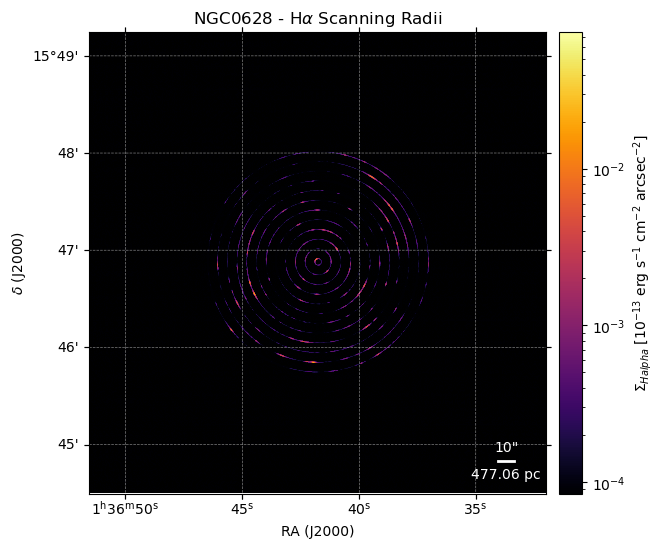

In [8]:
masked_rings = np.zeros_like(cropped_image)
rings_with_nan = [data for data in pixels_data if np.isnan(data).any()]
rings_without_nan = [data for data in pixels_data if not np.isnan(data).any()]
print('Array w/o nan found: ' + str(len(rings_without_nan)))
print('Over an original sample of ' + str(len(pixels_data)))

sampled_rings = []

for w, data in enumerate(rings_without_nan):
    if (w % 10)==0:
        sampled_rings.append(data)
        y = data[:, 0].astype(int)
        x = data[:, 1].astype(int)
        values = data[:, 2]
        masked_rings[y, x] = values
print('Sampled rings: ' + str(len(sampled_rings)))

fig, ax = plt.subplots(figsize=(8, 6), subplot_kw={'projection': wcs_cropped}, dpi=100)

cmap = plt.cm.inferno.copy()
cmap.set_bad(color='black')

im = ax.imshow(masked_rings, cmap=cmap, origin="lower", norm=LogNorm(vmin=np.nanmin(masked_rings[masked_rings>0]), vmax=np.nanmax(masked_rings)))

ax.set_xlabel("RA (J2000)")
ax.set_ylabel("$\delta$ (J2000)")
ax.grid(color='white', linestyle='--', linewidth=0.5, alpha=0.5)
#ax.set_xlim(image_center[0]-500,image_center[0]+500)
#ax.set_ylim(image_center[1]-500,image_center[1]+500)

x_start = cropped_image.shape[1] - 150
y_position = 100
ax.plot([x_start, x_start + (arcsecond_length_in_pixels*10)], [y_position, y_position], color='white', lw=2)
ax.text(x_start + (arcsecond_length_in_pixels*10) / 2, y_position + 20, "10\"", color='white', va='bottom', ha='center', fontsize=10)
ax.text(x_start + (arcsecond_length_in_pixels*10) / 2, y_position - 40, f"{(arcsecond_to_pc*10):.2f} pc", color='white', va='center', ha='center', fontsize=10)

ax.set_title(r"NGC0628 - H$\alpha$ Scanning Radii")
cbar = plt.colorbar(im, ax=ax, pad=0.02)
cbar.set_label("$\Sigma_{Halpha}$ [10$^{-13}$ erg s$^{-1}$ cm$^{-2}$ arcsec$^{-2}$]")
plt.show()

## Selecting scanning radii and power spectra

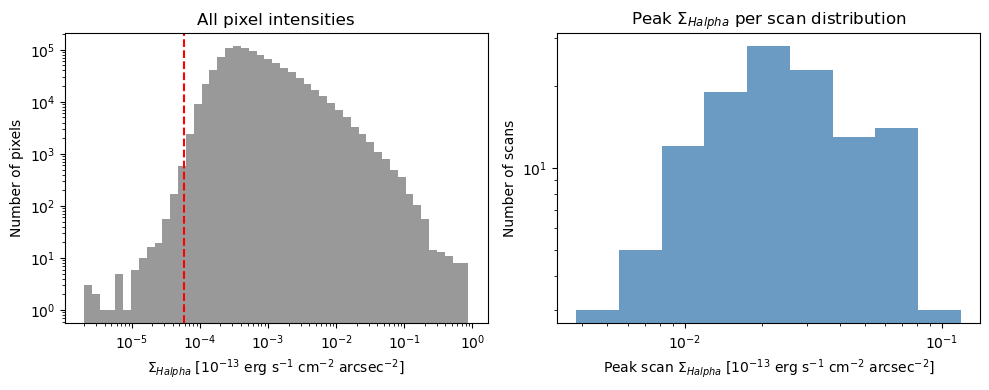

In [9]:
cropped_image_flat = cropped_image[np.isfinite(cropped_image)]
cropped_image_flat = cropped_image_flat[cropped_image_flat > 0]
peak_intensities = []
for ring in pixels_data:
    intensities = ring[:, 2]
    peak_intensities.append(np.max(intensities))
    
fig, axes = plt.subplots(1, 2, figsize=(10, 4), dpi=100)

axes[0].hist(cropped_image_flat, bins=np.logspace(np.log10(np.nanmin(cropped_image_flat)), np.log10(np.nanmax(cropped_image_flat)), 50), color='gray', alpha=0.8)
axes[0].axvline(3*mean_background, color='red', linestyle='--', label=r'3$\sigma$ noise')
axes[0].set_xscale('log')
axes[0].set_yscale('log')
axes[0].set_xlabel("$\Sigma_{Halpha}$ [10$^{-13}$ erg s$^{-1}$ cm$^{-2}$ arcsec$^{-2}$]")
axes[0].set_ylabel("Number of pixels")
axes[0].set_title("All pixel intensities")

axes[1].hist(peak_intensities, bins=np.logspace(np.log10(np.nanmin(peak_intensities)), np.log10(np.nanmax(peak_intensities)), 10), color='steelblue', alpha=0.8)
axes[1].set_xscale('log')
axes[1].set_yscale('log')
axes[1].set_xlabel("Peak scan $\Sigma_{Halpha}$ [10$^{-13}$ erg s$^{-1}$ cm$^{-2}$ arcsec$^{-2}$]")
axes[1].set_ylabel("Number of scans")
axes[1].set_title("Peak $\Sigma_{Halpha}$ per scan distribution")

plt.tight_layout()
plt.show()

I established to perform the cut at 0.02 $\Sigma_{Halpha}$


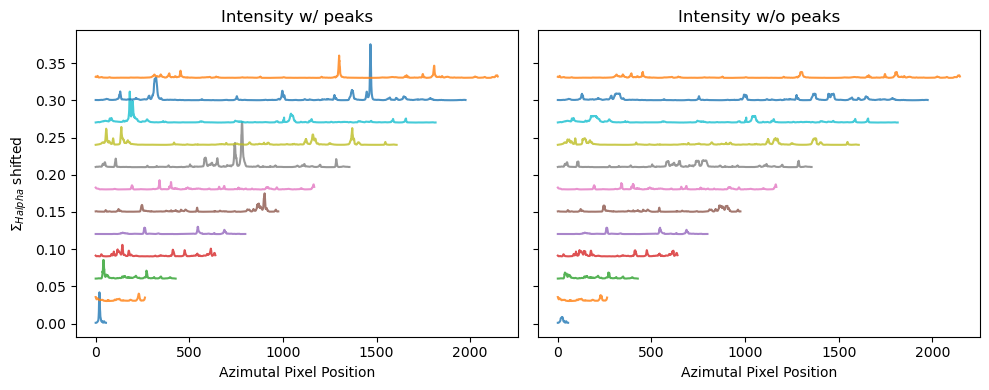

In [10]:
print(r'I established to perform the cut at 0.02 $\Sigma_{Halpha}$')
suppressed_rings = []

def suppress_peaks(intensities, threshold, window_size=10):
    suppressed_intensities = intensities.copy()
    
    for i in range(len(intensities)):
        if intensities[i] > threshold:
            start = max(0, i - window_size)
            end = min(len(intensities), i + window_size + 1)
            local_mean = np.mean(intensities[start:end])
            suppressed_intensities[i] = local_mean
    
    return suppressed_intensities

fig, axes = plt.subplots(1, 2, figsize=(10, 4), dpi=100, sharey=True)
for w, data in enumerate(sampled_rings):
    y, x = data[:, 0], data[:, 1]
    intensities = data[:, 2]
    azimuthal_angles = np.arctan2(y - image_center[1], x - image_center[0])
    azimuthal_angles = np.mod(azimuthal_angles, 2 * np.pi)
    sorted_indices = np.argsort(azimuthal_angles)
    intensities_sorted = intensities[sorted_indices]
    pixel_index = np.arange(len(intensities_sorted))
    axes[0].plot(pixel_index, intensities_sorted + 0.03 * w, alpha=0.8)
axes[0].set_title("Intensity w/ peaks")
axes[0].set_xlabel("Azimutal Pixel Position")
axes[0].set_ylabel("$\Sigma_{Halpha}$ shifted")

for w, data in enumerate(sampled_rings):
    y, x = data[:, 0], data[:, 1]
    intensities = data[:, 2]
    suppressed_intensities = suppress_peaks(intensities, 0.009)
    for i in np.arange(10):
        suppressed_intensities = suppress_peaks(suppressed_intensities, 0.009)
    suppressed_rings.append(np.column_stack((y, x, suppressed_intensities)))
    azimuthal_angles = np.arctan2(y - image_center[1], x - image_center[0])
    azimuthal_angles = np.mod(azimuthal_angles, 2 * np.pi)
    sorted_indices = np.argsort(azimuthal_angles)
    suppressed_intensities_sorted = suppressed_intensities[sorted_indices]
    pixel_index = np.arange(len(suppressed_intensities_sorted))
    axes[1].plot(pixel_index, suppressed_intensities_sorted + 0.03 * w, alpha=0.8)
axes[1].set_title("Intensity w/o peaks")
axes[1].set_xlabel("Azimutal Pixel Position")

plt.tight_layout()
plt.show()


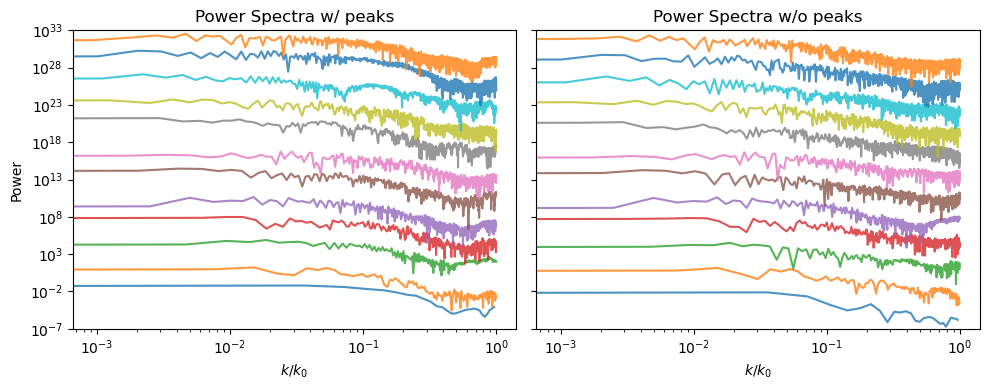

In [11]:
def compute_power_spectrum(intensities, pixel_scale=pixel_scale, arcsecond_to_pc=arcsecond_to_pc):
    intensities = np.array(intensities)
    intensities = intensities - np.nanmean(intensities)
    intensities[np.isnan(intensities)] = 0
    fft_vals = np.fft.fft(intensities)
    power_spectrum = np.abs(fft_vals) ** 2
    n = len(intensities)
    k = np.fft.fftfreq(n) / (arcsecond_to_pc * pixel_scale)
    k0 = 1 / (2 * arcsecond_to_pc * pixel_scale)
    k_over_k0 = np.abs(k) / k0
    return k_over_k0[:n // 2], power_spectrum[:n // 2]

fig, axes = plt.subplots(1, 2, figsize=(10, 4), dpi=100, sharey=True)

for w, data in enumerate(sampled_rings):
    intensities = data[:, 2]
    azimuthal_angles = np.arctan2(data[:, 0] - image_center[1], data[:, 1] - image_center[0])
    azimuthal_angles = np.mod(azimuthal_angles, 2 * np.pi)
    sorted_indices = np.argsort(azimuthal_angles)
    intensities_sorted = intensities[sorted_indices]
    k_over_k0, Pk = compute_power_spectrum(intensities_sorted)
    axes[0].loglog(k_over_k0, Pk * 10 ** (3.0 * w), alpha=0.8)

axes[0].set_ylim(1e-7,1e33)
axes[0].set_title("Power Spectra w/ peaks")
axes[0].set_xlabel(r"$k/k_0$")
axes[0].set_ylabel("Power")

for w, data in enumerate(suppressed_rings):
    intensities = data[:, 2]
    suppressed_intensities = intensities.copy()
    azimuthal_angles = np.arctan2(data[:, 0] - image_center[1], data[:, 1] - image_center[0])
    azimuthal_angles = np.mod(azimuthal_angles, 2 * np.pi)
    sorted_indices = np.argsort(azimuthal_angles)
    suppressed_sorted = suppressed_intensities[sorted_indices]
    k_over_k0, Pk = compute_power_spectrum(suppressed_sorted)
    axes[1].loglog(k_over_k0, Pk * 10 ** (3.0 * w), alpha=0.8)
    
axes[1].set_title("Power Spectra w/o peaks")
axes[1].set_xlabel(r"$k/k_0$")

plt.tight_layout()
plt.show()


## Using different thresholds to have Figure 4 (Elmegreen)

In [12]:
def average_power_spectra(rings, pixel_scale=pixel_scale, arcsecond_to_pc=arcsecond_to_pc):
    ps_list = []
    kgrids = []
    for data in rings:
        intensities = data[:, 2]
        azimuthal_angles = np.arctan2(data[:, 0] - image_center[1], data[:, 1] - image_center[0])
        azimuthal_angles = np.mod(azimuthal_angles, 2 * np.pi)
        sorted_indices = np.argsort(azimuthal_angles)
        sorted_intensities = intensities[sorted_indices]
        k_over_k0, Pk = compute_power_spectrum(sorted_intensities, pixel_scale, arcsecond_to_pc)
        ps_list.append(Pk)
        kgrids.append(k_over_k0)
    k_common = kgrids[np.argmax([len(k) for k in kgrids])]
    interp_ps = [np.interp(k_common, k, ps) for k, ps in zip(kgrids, ps_list)]
    avg_ps = np.mean(interp_ps, axis=0)
    return k_common, avg_ps
    
def compute_running_slope(k_common, avg_ps, bins=50):
    log_k = np.log10(k_common)
    log_p = np.log10(avg_ps)
    mask = np.isfinite(log_k) & np.isfinite(log_p)
    log_k = log_k[mask]
    log_p = log_p[mask]
    
    bin_edges = np.linspace(log_k.min(), log_k.max(), bins + 1)
    bin_centers = []
    mean_log_p = []
    mean_log_k = []

    for i in range(bins):
        bin_mask = (log_k >= bin_edges[i]) & (log_k < bin_edges[i + 1])
        if np.any(bin_mask):
            mean_log_k.append(np.mean(log_k[bin_mask]))
            mean_log_p.append(np.mean(log_p[bin_mask]))
            bin_centers.append(0.5 * (bin_edges[i] + bin_edges[i + 1]))

    mean_log_k = np.array(mean_log_k)
    mean_log_p = np.array(mean_log_p)
    bin_centers = np.array(bin_centers)

    slope = np.full_like(bin_centers, np.nan)
    for i in range(1, len(bin_centers) - 1):
        delta_log_p = mean_log_p[i + 1] - mean_log_p[i - 1]
        delta_log_k = mean_log_k[i + 1] - mean_log_k[i - 1]
        if delta_log_k != 0:
            slope[i] = delta_log_p / delta_log_k

    k_slope = 10 ** mean_log_k
    return k_slope, slope

In [13]:
avg_ps_list = []
k_list = []
running_slope_list = []
k_slope_list = []

max_intensities = np.array([np.nanmax(r[:, 2]) for r in rings_without_nan])
sorted_max = np.sort(max_intensities)
cutoff_indices = np.linspace(0, len(sorted_max), 7, endpoint=True).astype(int)[1:-1]
cutoffs = sorted_max[cutoff_indices]
bins = np.digitize(max_intensities, bins=cutoffs)
unique, counts = np.unique(bins, return_counts=True)
print(list(zip(unique, counts)))

for cutoff in cutoffs:
    selected = [r for r, max_i in zip(rings_without_nan, max_intensities) if max_i < cutoff]
    print(len(selected))
    if len(selected) == 0:
        continue
    k_common, avg_ps = average_power_spectra(selected)
    k_slope, slope = compute_running_slope(k_common, avg_ps)
    k_list.append(k_common)
    avg_ps_list.append(avg_ps)
    k_slope_list.append(k_slope)
    running_slope_list.append(slope)

[(0, 20), (1, 20), (2, 20), (3, 20), (4, 20), (5, 20)]
20
40
60
80
100


/tmp/ipykernel_130391/943630648.py:19: RuntimeWarning: divide by zero encountered in log10
  log_k = np.log10(k_common)


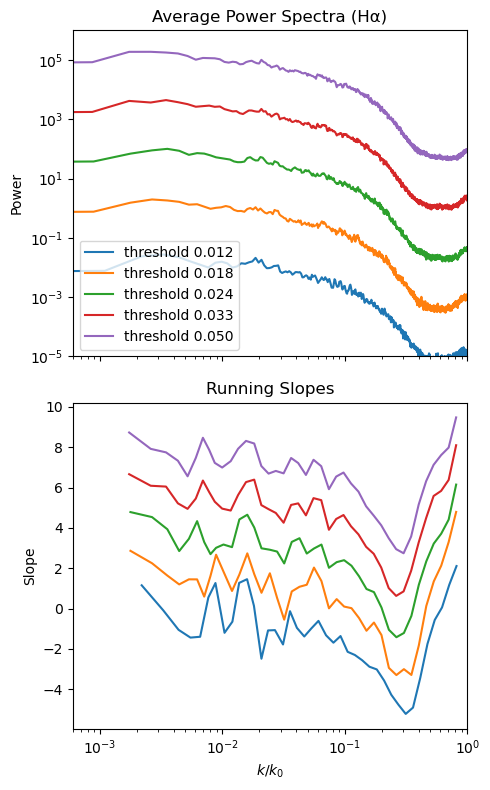

In [14]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(5, 8), dpi=100, sharex=True)

for i in range(len(avg_ps_list)):
    ax1.loglog(k_list[i], avg_ps_list[i] * 10 ** (1.5 * i), label=f"threshold {cutoffs[i]:.3f}")
    ax2.semilogx(k_slope_list[i], running_slope_list[i] + 2 * i)

ax1.set_ylabel("Power")
ax1.set_title("Average Power Spectra (Hα)")
ax1.legend()
ax1.set_ylim(1e-5,1e6)
ax1.set_xlim(6e-4,1)

ax2.set_xlabel(r"$k/k_0$")
ax2.set_ylabel("Slope")
ax2.set_title("Running Slopes")

plt.tight_layout()
plt.show()


# Power Spectra and running slopes for JWST/MIRI

## Extracting the MIRI filters (with native PSF)

In [16]:
miri_images = {"F770W": "hlsp_phangs-jwst_jwst_miri_ngc0628_f770w_v1p1_img.fits",
    "F1000W": "hlsp_phangs-jwst_jwst_miri_ngc0628_f1000w_v1p1_img.fits",
    "F1130W": "hlsp_phangs-jwst_jwst_miri_ngc0628_f1130w_v1p1_img.fits",
    "F2100W": "hlsp_phangs-jwst_jwst_miri_ngc0628_f2100w_v1p1_img.fits"}
miri_psf = [0.269, 0.328, 0.375, 0.674]

for i, (filter_name, _) in enumerate(miri_images.items()):
    print(str(filter_name) + ' PSF:  ' + str(miri_psf[i]) + ' arcsec; ' + str(miri_psf[i] * arcsecond_to_pc) + ' pc')

F770W PSF:  0.269 arcsec; 12.832812159115702 pc
F1000W PSF:  0.328 arcsec; 15.647443822267473 pc
F1130W PSF:  0.375 arcsec; 17.88960802850702 pc
F2100W PSF:  0.674 arcsec; 32.153588829903285 pc


# Old codes

In [46]:
pixel_values = cropped_image.flatten()
pixel_values = pixel_values[np.isfinite(pixel_values)]
background_pixels = pixel_values[pixel_values < np.percentile(pixel_values, 68)]
sigma = np.std(background_pixels)

def extract_circle_intensity(image, center, radius, num_points=2000):
    theta = np.linspace(0, 2 * np.pi, num_points, endpoint=False)
    x = center[0] + radius * np.cos(theta)
    y = center[1] + radius * np.sin(theta)
    coords = np.vstack((y, x))  # y prima perché le immagini usano (row, col)
    values = map_coordinates(image, coords, order=1, mode='reflect')
    return values

def compute_power_spectrum(intensity_profile):
    profile_detrended = intensity_profile - np.mean(intensity_profile)
    fft_vals = np.fft.rfft(profile_detrended)
    power = np.abs(fft_vals) ** 2
    k = np.fft.rfftfreq(len(intensity_profile), d=1.0)
    return k, power

def is_clean_scan(intensity_profile, threshold):
    return np.max(intensity_profile) < threshold

clean_scans = []
power_spectra = []

for r in radii:
    intensities = extract_circle_intensity(cropped_image, (cropped_image.shape[1] // 2, cropped_image.shape[0] // 2), r)
    
    if is_clean_scan(intensities, threshold=1e3):
        k, power = compute_power_spectrum(intensities)
        power_spectra.append((k, power))
        clean_scans.append((r, intensities))

power_spectra = np.array(power_spectra)

print(f"{len(clean_scans)} clean scans found on a total of {len(radii)}")
print(f"Bins needed: " + str(np.sqrt(len(clean_scans))))

120 clean scans found on a total of 232
Bins needed: 10.954451150103322


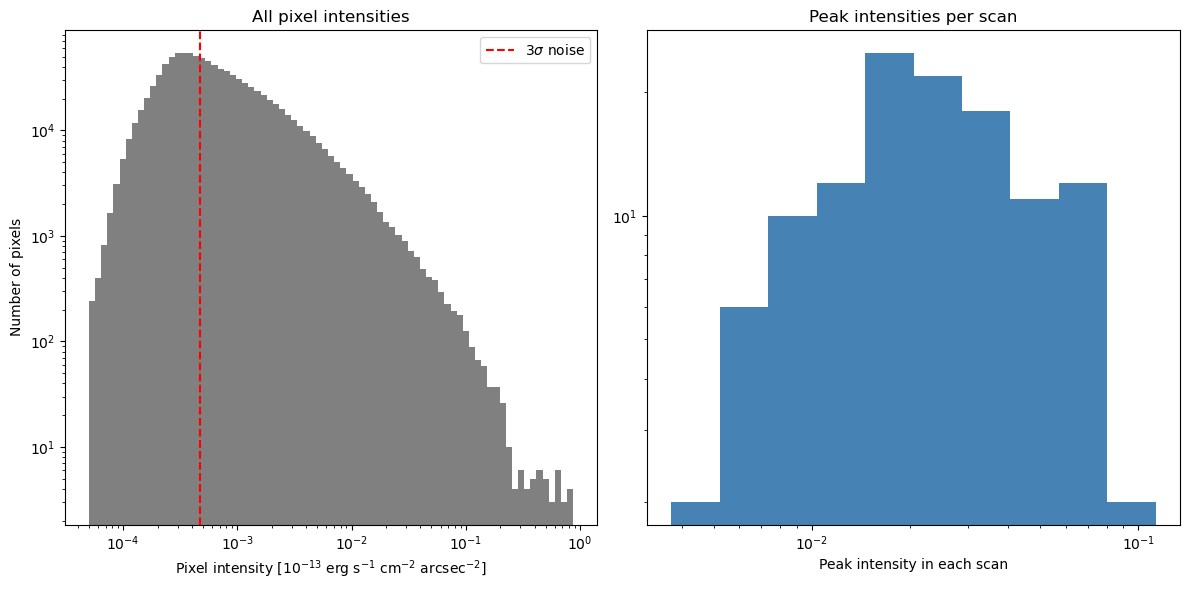

In [47]:
log_bins_pixel = np.logspace(np.log10(5e-5), np.log10(np.max(pixel_values)), 600)
log_bins_scans = np.logspace(np.log10(np.min([np.max(scan) for _, scan in clean_scans])), np.log10(np.max([np.max(scan) for _, scan in clean_scans])), 11)


fig, axs = plt.subplots(1, 2, figsize=(12, 6), dpi=100)
axs[0].hist(pixel_values, bins=log_bins, color='gray', log=True)
axs[0].axvline(sigma * 3, color='red', linestyle='--', label=r'3$\sigma$ noise')
axs[0].set_xlabel("Pixel intensity [10$^{-13}$ erg s$^{-1}$ cm$^{-2}$ arcsec$^{-2}$]")
axs[0].set_ylabel("Number of pixels")
axs[0].set_title("All pixel intensities")
axs[0].set_xscale('log')
axs[0].legend()

axs[1].hist([np.max(scan) for _, scan in clean_scans], bins=log_bins_scans, color='steelblue', log=True)
axs[1].set_xscale('log')
axs[1].set_xlabel("Peak intensity in each scan")
axs[1].set_title("Peak intensities per scan")

plt.tight_layout()
plt.show()